In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [31]:
def FFBS(vy, mF, vV, amG, amW, vm0, mC0):
    
    T, p = vy.shape[0], mF.shape[0]
    ma = np.zeros((T, p))
    mm = np.zeros((T, p))
    mb = np.zeros((T, p))
    amR = [np.eye(p)]*T
    amC = [np.eye(p)]*T
    amb = np.zeros(T)
    
    vm = vm0
    mC = mC0
    
    # ff loop
    for t in range(T):
        
        if t > 0:
            vm = mm[t-1,:]
            mC = amC[t-1]
        
        ma[t, :] = vm*amG[t]
        amR[t] = amG[t]*mC*amG[t]+ amW[t]
        dq = amR[t] + vV[t]
        mA = amR[t]/dq

        m = vm*amG[t] + mA*(vy[t] - vm*amG[t])
        mm[t, :] = m
        
        C = amR[t] - mA*mA*dq
        amC[t] = C
    
    # BS loop
    C_float = C.astype(np.float64)
    mb = np.random.normal(m.astype(np.float64), np.sqrt(C_float))
 
    amb[T-1] = mb
    
    for t in reversed(range(T-1)): 
        
        mB = amC[t]*amG[t+1]/amR[t+1]
        mH = amC[t] - [mB*mB*amR[t+1]]
        mean = mm[t, :] + (mb - ma[t+1, :])*mB
        H_float = mH.astype(np.float64)
        mb = mean.astype(np.float64) + np.random.normal(np.zeros(p), np.sqrt(H_float))

        amb[t] = mb
        
    return amb

In [32]:
np.random.seed(12345)
# prepare
vy = pd.read_csv("sv_simdataHW10.csv").values[0][1:]
nT = vy.shape[0]
vy_star = np.array([np.log(i**2) for i in vy])
nsim = 5000
nburn = 1000
dC0 = 2

# priors
## mu
dmm = 0
dCm = 1
## phi
dmp = 0.9
dCp = 0.1
## sigma
da0 = 0.1
db0 = 0.1

# mixture setup
nK = 10
vp_mix = [0.00609, 0.04775, 0.13057,0.20674,0.22715,0.18842,0.12047,0.05591,0.01575,0.00115]
vm_mix = [1.92677,1.34744,0.73504,0.02266,-0.85173,-1.97278,-3.46788,-5.55246,-8.68384,-14.65000]
vv2_mix = [0.11265,0.17788,0.26768,0.40611,0.62699,0.98583,1.57469,2.54498,4.16591,7.33342]

# initial values
dmu = dmm + np.sqrt(dCm) * np.random.normal()
while True:
    dphi = np.random.normal(loc = dmp, scale = np.sqrt(dCp))
    if abs(dphi) < 1:
        break
dsig2 = 1/np.random.gamma(da0, db0)
vs = np.random.choice(len(vp_mix), nT, p=vp_mix)

amG = [np.array([dphi])]*nT
amW = [np.array([dsig2])]*nT
mF = np.ones((1, nT))
mh = np.zeros((nsim, nT+1))
vphi = np.zeros(nsim)
vmu = np.zeros(nsim)
vsig2 = np.zeros(nsim)

In [33]:
# MCMC

# fix phi, sigma, mu

#dphi = 0.97
#dsig2 = 0.15**2
#dmu = 2*np.log(0.65)

for i in range(nsim):
    
    # FFBS part
    vy_star2 = vy_star - dmu - np.array([vm_mix[j] for j in vs])
    vV = np.array([vv2_mix[j] for j in vs])
    amG = [np.array([dphi])]*nT
    amW = [np.array([dsig2])]*nT
    vh_star = FFBS(vy_star2,mF,vV,amG,amW,np.array([dmu]),dC0*dsig2)

    # posterior for h_0^star
    vhstar0 = np.random.normal(vh_star[0]*dphi*dC0/(dphi**2 * dC0 + 1), np.sqrt(dsig2 * dC0/(dphi**2 * dC0 + 1)))
    vh_star = np.hstack((np.array([vhstar0]), vh_star)) 

    # sampling phi
    S1 = np.sum([vh_star[i]**2 for i in range(0, nT)])
    S2 = np.sum([vh_star[i]*vh_star[i-1] for i in range(1, nT+1)])
    alpha = S2/S1
    beta2 = dsig2/S1
    dmphi = (alpha * dCp + dmp * beta2)/(beta2 + dCp)
    dCphi = beta2*dCp/(beta2 + dCp)
    dphi = np.random.normal(loc = dmphi, scale = np.sqrt(dCphi))
    
    # sampling sigma
    S3 = np.sum([(vh_star[i] - dphi*vh_star[i-1])**2 for i in range(1, nT+1)])
    da = (nT + 1)/2 + da0
    db = 1/(db0 + S3/2)
    dsig2 = 1/np.random.gamma(shape = da, scale = db)
    
    # sampling mu
    vh = [i + dmu for i in vh_star]
    S4 = np.sum([vh[i] - dphi*vh[i-1] for i in range(1, nT+1)])
    delta = (vh[0] + dC0*(1-dphi)*S4)/(1 + dC0*nT*(1-dphi)**2)
    eta2 = dsig2*dC0/(1 + dC0*nT*(1-dphi)**2)
    dmmu = (delta * dCm + dmm * eta2)/(dCm + eta2)
    dCmu = dCm * eta2 / (dCm + eta2)
    dmu = np.random.normal(loc = dmmu, scale = np.sqrt(dCmu))

    # sampling latent
    #vy_star2 = vy_star - dmu - np.array([vm_mix[j] for j in vs])
    for t in range(nT):
        vp = [vp_mix[k] * np.exp(-(vy_star[t] - dmu - vm_mix[k] - vh_star[t+1])**2/(2 * vv2_mix[k])) / (np.sqrt(2*np.pi*vv2_mix[k])) for k in range(nK)]
        newvp = [p/sum(vp) for p in vp]
        vs[t] = np.random.choice(len(newvp), 1, p=newvp)
        
    # store
    if i >= 0:
        vh = [i + dmu for i in vh_star]
        mh[i][:] = vh
        vphi[i] = dphi
        vmu[i] = dmu
        vsig2[i] = dsig2

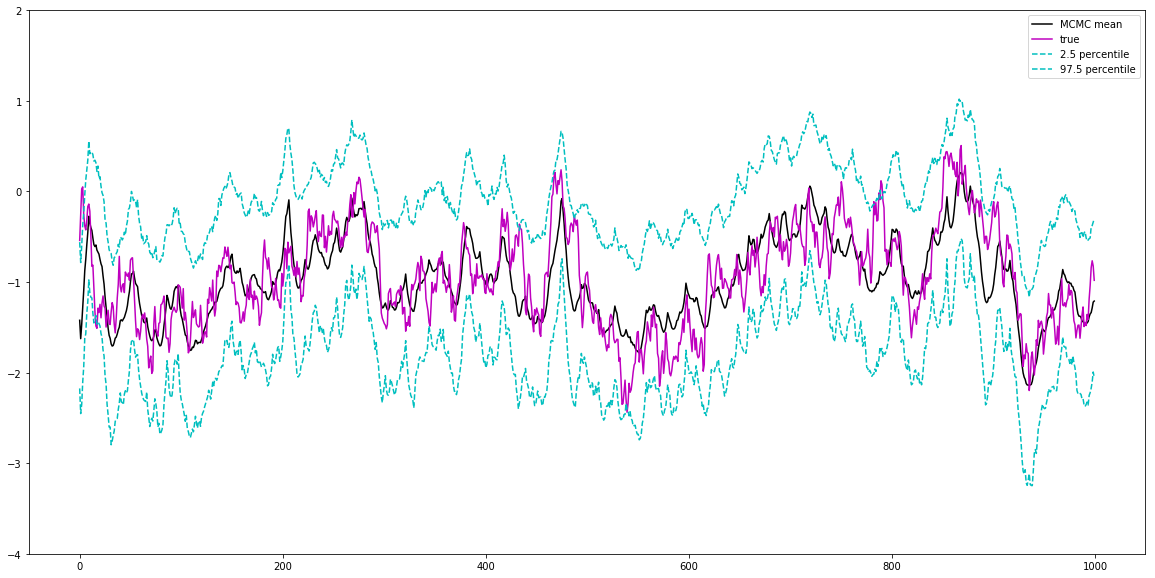

In [58]:
df = pd.read_csv("sv_truevol10.csv")
truevol = df.values[0][1:]

result = np.zeros(nT)
lquant = np.zeros(nT)
uquant = np.zeros(nT)
for t in range(nT):
    result[t] = np.mean(mh[nburn:, t])
    lquant[t] = np.percentile(mh[nburn:, t], 2.5)
    uquant[t] = np.percentile(mh[nburn:, t], 97.5)

plt.figure(figsize=(20, 10)) 
plt.plot(result, 'k', label = 'MCMC mean')
plt.plot(truevol, 'm' , label = 'true')
plt.plot(lquant, 'c--', label = '2.5 percentile')
plt.plot(uquant, 'c--', label = '97.5 percentile')
plt.ylim(-4, 2)
plt.legend()
plt.show()

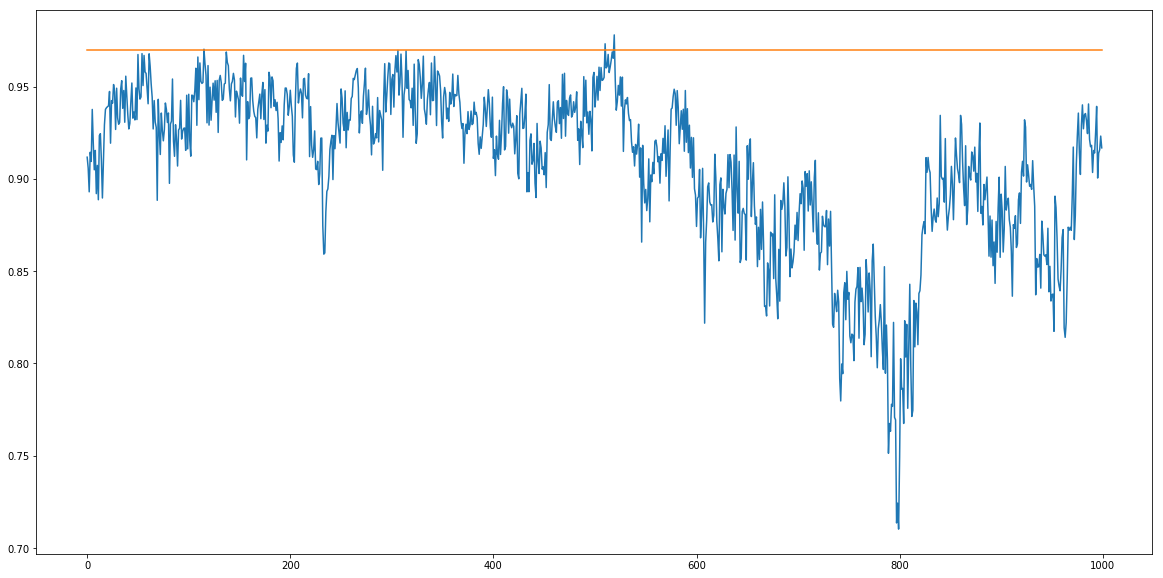

In [70]:
truephi = np.ones(nsim-nburn)*0.97
plt.figure(figsize=(20, 10))
plt.plot(vphi[nburn:])
plt.plot(truephi)
plt.show()

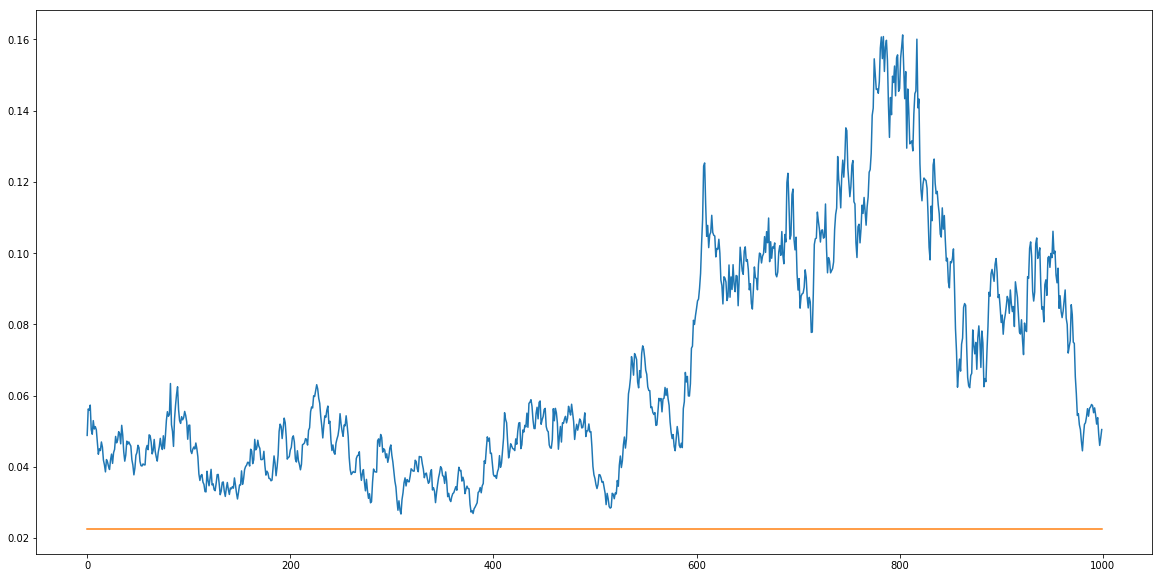

In [71]:
truesig = np.ones(nsim-nburn)*0.15**2
plt.figure(figsize=(20, 10)) 
plt.plot(vsig2[nburn:])
plt.plot(truesig)
plt.show()

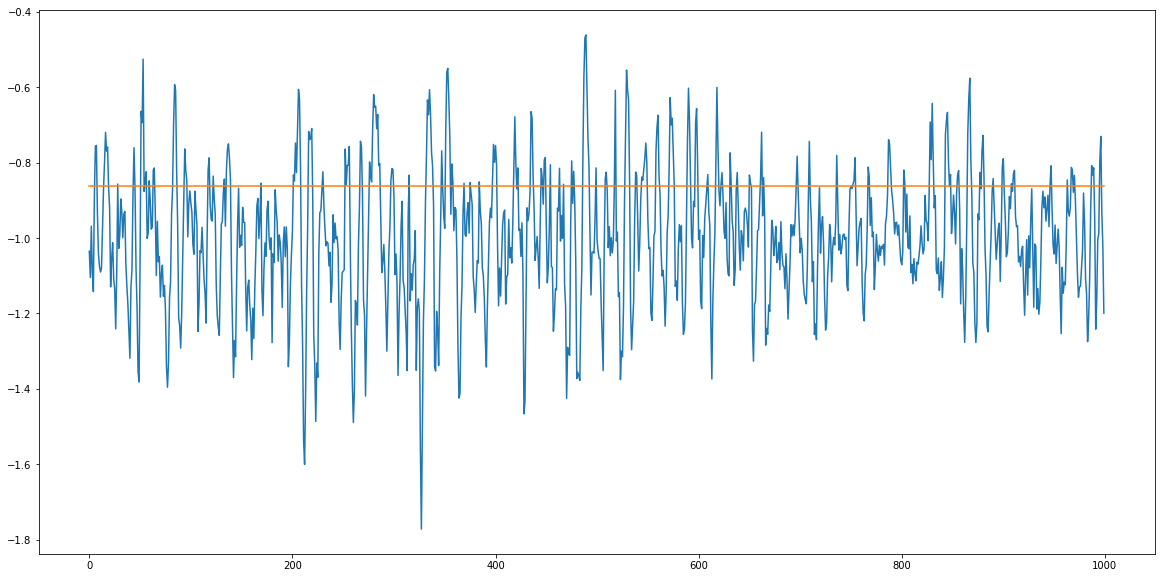

In [72]:
truemu = np.ones(nsim-nburn)*2*np.log(0.65)
plt.figure(figsize=(20, 10)) 
plt.plot(vmu[nburn:])
plt.plot(truemu)
plt.show()